## Import necessary modules. 
Use 'ai4reg' for kernel. Note that the code was tested with Tensorflow 2.12. 
Some commands below do not work with newer versions of Tensorflow. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from numpy import mean
from numpy import std

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
from datetime import datetime

2024-11-19 11:16:13.569251: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Fix the random seed for producible results

In [2]:
# Seed value
seed = 1
# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed)

# 3. Set the `numpy` pseudo-random generator at a fixed value
np.random.seed(seed)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.random.set_seed(seed)

# 5. Configure a new global `tensorflow` session
from tensorflow.compat.v1.keras.backend import set_session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

## Download the saved model 

### This will work only if you saved a model from "01a_Multivariate_LSTM_magnetic-prediction.ipynb" before (preferably from Task 2 specified at the end of that notebook).  

In [3]:
# Paths of the initial model and scaler
initial_model = "Saved_models/Multivariate_LSTM_magnetic-prediction_clean/model_weights.best.hdf5"
scaler_file = "Scaler_magnetic-prediction.pkl"

print("This code will update the model: ", initial_model)
print("We are currently using the scaler: ", scaler_file)

This code will update the model:  Saved_models/Multivariate_LSTM_magnetic-prediction/model_weights.best.hdf5
We are currently using the scaler:  Scaler_magnetic-prediction.pkl


## Neural network model 

In [4]:
model = tf.keras.models.load_model(initial_model)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 100)         44400     
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          30200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 94,953
Trainable params: 94,953
Non-trainable params: 0
_________________________________________________________________


## Download data
The file below contains the hourly measurements of the interplanetary magnetic field (IMF), solar wind, and the ground magnetic field variation from 1995 to the end of 2019. The IMF and solar wind measurements were made by spacecraft upstream of the Earth. The ground magnetic field measurements were made at Chambon-la-Forêt observatory. The file has 14 columns including the timestamps: 

- **time**: time of the measurements in format yyyy-mm-dd HH:MM:SS
- **Bx_gse**: the x-component of the IMF in nanoTesla, where x points towards the Sun
- **By_gse**: the y-component of the IMF in nanoTesla, where y points duskward
- **By_gsm**: the z-component of the IMF in nanoTesla, where z points northward and aligns with the Earth's magnetic dipole
- **V**: the solar wind speed in km/s
- **N**: the solar wind proton number density in cm^-3
- **Temp**: the solar wind proton temperature in eV
- **F10.7**: the solar radio flux measurements. This parameter is measured once a day but then interpolated to hourly cadence.
- **local_time**: the local time of measurements in UT, from 0 to 23
- **DistSE**: the distance between Sun and Earth in astronomical units (A.U.), to be used as proxy for seasonal variation
- **xD**: the x-component (geographic north) of the ground magnetic field daily variation, in nanoTesla
- **yD**: the y-component (geographic east) of the ground magnetic field daily variation, in nanoTesla
- **zD**: the z-component (downward, towards the Earth core) of the ground magnetic field daily variation, in nanoTesla
 

In [5]:
# Download the file 
inputfile = 'Data/solarw_geometry_magdaily_1995-2020_hourly.csv'

df = pd.read_csv(inputfile)
df['time'] = pd.to_datetime(df['time'])
df = df.set_index(['time']) # Make timestamp as index 
df

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.20,0.983325,-0.977299,4.004956,-0.684950
1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.96,0.983324,-1.811840,1.059523,-0.683473
1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.80,0.983324,0.263458,-1.224260,-0.733840
1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.70,0.983323,2.129897,-2.761787,-0.623952
1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.83,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28 19:00:00,2.0,-1.1,-1.0,318.0,5.6,37794.0,69.8,19.0,118.15,0.983387,0.224158,1.435973,0.180608
2019-12-28 20:00:00,-2.6,-1.9,0.7,334.0,6.8,31737.0,69.8,20.0,128.20,0.983385,-0.327949,2.823559,0.030450
2019-12-28 21:00:00,-2.6,-2.1,-0.1,333.0,6.6,28100.0,69.8,21.0,137.97,0.983384,-0.394458,4.494567,0.140903


## Problem formulation: update the model training with newer data

Our model was trained using data between 1995 and 1997 and validated with data from January to March in 1998. 

Supposing that now we want to update the model every year as the data become available. For example, we will update the model until end of 1999, for the model to be validated and tested in 2000. 

In this exercise, we will update our model training using a sliding window or Walk Forward Validation. This approach has been used in economy and stock market predictions where the model is retrained once newer data become available. The advantage is that the model would be the most up-to-date, making it more relevant to the current situation and thus the near future situation. We will demonstrate these in this worksheet.

## Defining train, validation, and test data to train a machine learning model
For sequential data, it is important to keep the order of the sequence. 

Here, we will specify 1 year of training data, 2 weeks of validation, and 2 weeks of test data. 

In [6]:
## Beginning of the dataset 
t1 = datetime(1995,1,1,0,0,0)

## The test interval: the model will be updated up until the test interval 
t_test_begin = datetime(2000,4,1,0,0,0) 
t_test_end = datetime(2000,6,30,23,0,0)
print("Test interval: ", t_test_begin, t_test_end)

## All train interval including the walk forward intervals 
t_train_begin = t1 
t_train_end = t_test_begin - pd.Timedelta('1h')
print("All train interval including the walk forward intervals: ", t_train_begin, t_train_end)

## Global interval - all the data will be inside this range
t1 = t1
t2 = t_test_end
print("Global interval:", t1, t2)

Test interval:  2000-04-01 00:00:00 2000-06-30 23:00:00
All train interval including the walk forward intervals:  1995-01-01 00:00:00 2000-03-31 23:00:00
Global interval: 1995-01-01 00:00:00 2000-06-30 23:00:00


### Limit the data to the global interval of interest

In [7]:
df = df[t1:t2]
df

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.200,0.983325,-0.977299,4.004956,-0.684950
1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.960,0.983324,-1.811840,1.059523,-0.683473
1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.800,0.983324,0.263458,-1.224260,-0.733840
1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.700,0.983323,2.129897,-2.761787,-0.623952
1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.830,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-06-30 19:00:00,0.9,-4.6,-2.7,386.0,4.1,24970.0,165.0,19.0,83.258,1.016709,11.855123,-3.697526,9.997287
2000-06-30 20:00:00,4.2,-2.5,-1.7,357.0,4.8,26835.0,165.0,20.0,91.723,1.016710,11.172871,1.993873,9.893249
2000-06-30 21:00:00,3.4,-3.3,-2.3,363.0,4.7,20001.0,165.0,21.0,98.957,1.016710,6.869253,3.717582,7.675454


## Define input features and output targets 

In [8]:
input_features = ['Bx_gse','By_gsm','Bz_gsm','V','N','Temp','F10.7','local_time','SZA','DistSE']
output_targets = ['xD','yD','zD']

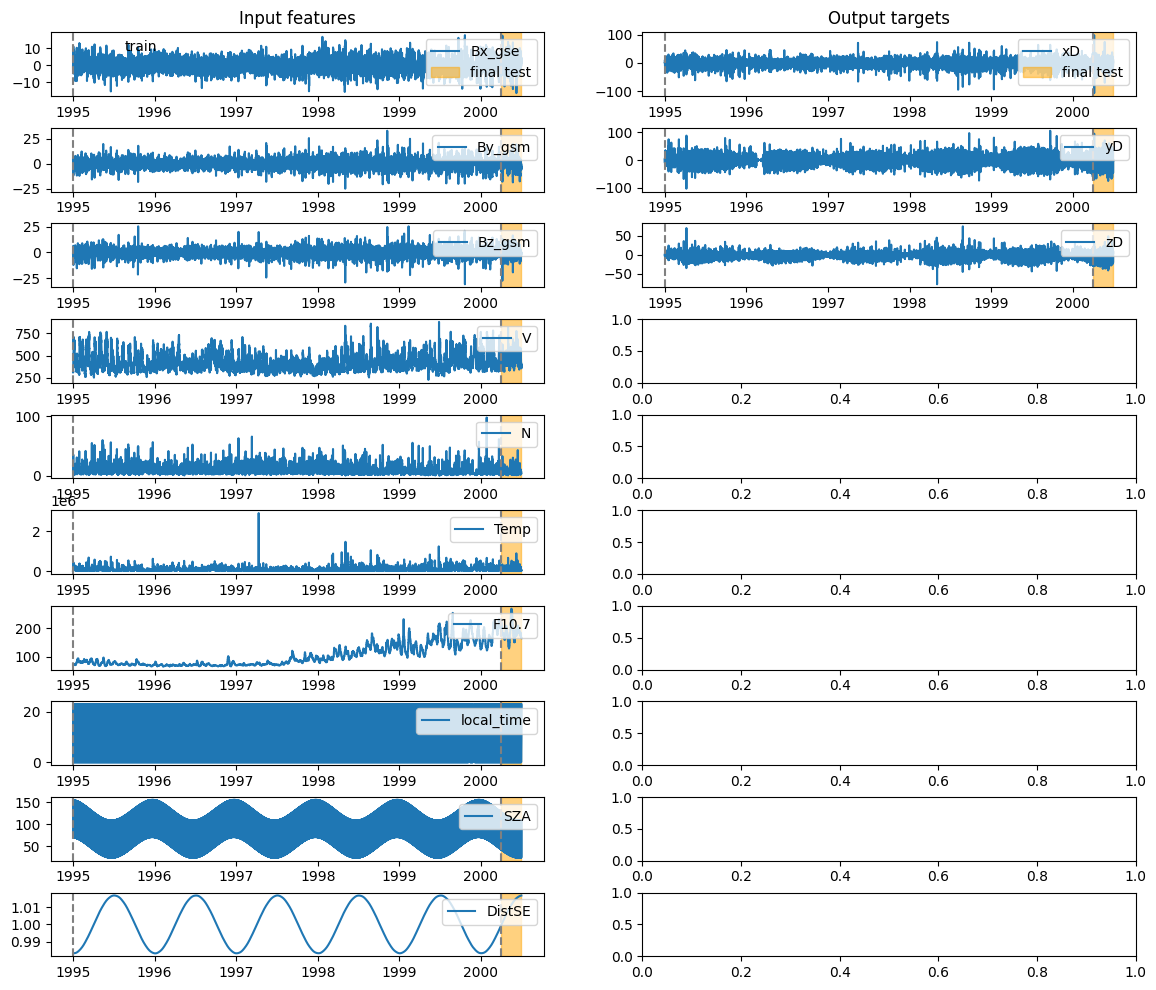

In [9]:
fig, ax = plt.subplots(len(input_features), 2, figsize=(14,12))
plt.subplots_adjust(hspace=0.5)

i = 0
for col in input_features:
    if i < len(input_features):
        ax[i,0].plot(df[col], label=col)
        ax[i,0].legend(loc='upper right',bbox_to_anchor=(1.0, 1.0))
        ax[i,0].axvline(x=t_train_begin, ls='--', color='grey')
        ax[i,0].axvline(x=t_train_end, ls='--', color='grey')
        ax[i,0].axvspan(xmin=t_test_begin, xmax=t_test_end, color='orange', alpha=0.5, label='final test')
        #ax[i,0].set_xlim(t1, t2)
        i += 1 
    
j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j,1].plot(df[col], label=col)
        ax[j,1].legend(loc='upper right',bbox_to_anchor=(1.0, 1.0))
        ax[j,1].axvline(x=t_train_begin, ls='--', color='grey')
        ax[j,1].axvline(x=t_train_end, ls='--', color='grey')
        ax[j,1].axvspan(xmin=t_test_begin, xmax=t_test_end, color='orange', alpha=0.5, label='final test')
        #ax[j,1].set_xlim(t1, t2)
        j += 1
    

ax[0,0].set_title('Input features')
ax[0,0].legend()
ax[0,0].text(0.15, 0.7, 'train', transform = ax[0,0].transAxes)

ax[0,1].set_title('Output targets')
ax[0,1].legend()

plt.show()

### Fix the order of the columns

In [10]:
df0 = df #save the original dataframe

new_column_order = ['Bx_gse','By_gsm','Bz_gsm','V','N','Temp','F10.7','local_time','SZA','DistSE','xD','yD','zD']
df = df[new_column_order]
df

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.200,0.983325,-0.977299,4.004956,-0.684950
1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.960,0.983324,-1.811840,1.059523,-0.683473
1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.800,0.983324,0.263458,-1.224260,-0.733840
1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.700,0.983323,2.129897,-2.761787,-0.623952
1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.830,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-06-30 19:00:00,0.9,-4.6,-2.7,386.0,4.1,24970.0,165.0,19.0,83.258,1.016709,11.855123,-3.697526,9.997287
2000-06-30 20:00:00,4.2,-2.5,-1.7,357.0,4.8,26835.0,165.0,20.0,91.723,1.016710,11.172871,1.993873,9.893249
2000-06-30 21:00:00,3.4,-3.3,-2.3,363.0,4.7,20001.0,165.0,21.0,98.957,1.016710,6.869253,3.717582,7.675454


## Divide the data before scaling

In [11]:
df_train = df[t_train_begin:t_train_end]
df_train

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.200,0.983325,-0.977299,4.004956,-0.684950
1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.960,0.983324,-1.811840,1.059523,-0.683473
1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.800,0.983324,0.263458,-1.224260,-0.733840
1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.700,0.983323,2.129897,-2.761787,-0.623952
1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.830,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-03-31 19:00:00,-3.7,-2.8,-4.4,374.0,6.4,13114.0,225.1,19.0,97.433,0.999278,-13.009748,11.203457,16.686207
2000-03-31 20:00:00,-2.7,-4.8,-3.2,377.0,6.4,11527.0,225.1,20.0,106.800,0.999291,-8.800562,17.348846,14.363314
2000-03-31 21:00:00,-3.3,-5.8,-2.1,375.0,7.4,8955.0,225.1,21.0,115.160,0.999303,0.226228,16.513900,11.633904


## Scale the train data

In [12]:
from pickle import load

# load the scaler
load_scaler = load(open(scaler_file, 'rb'))

In [13]:
## Scale the "train" data using the saved scaler
df_train_scaled = load_scaler.transform(df_train)

print('Train data: \n',df_train_scaled)
print(df_train_scaled.shape)

Train data: 
 [[0.52264808 0.49543379 0.46558704 ... 0.47794276 0.56151895 0.32872587]
 [0.51219512 0.47260274 0.4757085  ... 0.47185712 0.54615784 0.32873987]
 [0.56097561 0.4543379  0.48987854 ... 0.48699063 0.53424738 0.32826229]
 ...
 [0.42857143 0.28082192 0.44736842 ... 0.48671914 0.62675599 0.4455343 ]
 [0.38327526 0.28082192 0.451417   ... 0.55976623 0.6039606  0.41004348]
 [0.30662021 0.34018265 0.44736842 ... 0.59804283 0.58717536 0.36872456]]
(45691, 13)


# Define X (independent variables) and y (dependent variables)

In [14]:
## Get input 'X'
X_train = df_train_scaled[:,0:len(input_features)]

print('X train = \n',X_train)
print(X_train.shape)

## Get output 'y'
y_train = df_train_scaled[:,len(input_features):len(input_features)+len(output_targets)]

print('y train = \n',y_train)
print(y_train.shape)


X train = 
 [[0.52264808 0.49543379 0.46558704 ... 0.         0.99755889 0.00304821]
 [0.51219512 0.47260274 0.4757085  ... 0.04347826 0.97284267 0.00303238]
 [0.56097561 0.4543379  0.48987854 ... 0.08695652 0.91822287 0.00301674]
 ...
 [0.42857143 0.28082192 0.44736842 ... 0.91304348 0.69211522 0.47955586]
 [0.38327526 0.28082192 0.451417   ... 0.95652174 0.74337849 0.4799183 ]
 [0.30662021 0.34018265 0.44736842 ... 1.         0.77663859 0.4802807 ]]
(45691, 10)
y train = 
 [[0.47794276 0.56151895 0.32872587]
 [0.47185712 0.54615784 0.32873987]
 [0.48699063 0.53424738 0.32826229]
 ...
 [0.48671914 0.62675599 0.4455343 ]
 [0.55976623 0.6039606  0.41004348]
 [0.59804283 0.58717536 0.36872456]]
(45691, 3)


##  Transform X and y for Keras LSTM

In [15]:
def lstm_data_transform(x_data, y_data, num_steps=5):
    """ Changes data to the format for LSTM training """    # Prepare the list for the transformed data
    X, y = list(), list()    # Loop of the entire data set
    for i in range(x_data.shape[0]):
        # compute a new (sliding window) index
        end_ix = i + num_steps        # if index is larger than the size of the dataset, we stop
        if end_ix >= x_data.shape[0]:
            break        # Get a sequence of data for x
        seq_X = x_data[i:end_ix]
        # Get only the last element of the sequency for y
        seq_y = y_data[end_ix]        # Append the list with sequencies
        X.append(seq_X)
        y.append(seq_y)    # Make final arrays
    x_array = np.array(X)
    y_array = np.array(y)    
    return x_array, y_array

## Transform data to the sequences for LSTM network input

In [16]:
num_steps = 12 # 12 hours (1 hour cadence) 

X_train_seq, y_train_seq = lstm_data_transform(X_train, y_train, num_steps=num_steps)

print ("The new shape of X is", X_train_seq.shape)
print ("The new shape of y is", y_train_seq.shape)

The new shape of X is (45679, 12, 10)
The new shape of y is (45679, 3)


# Define Walk Forward steps 

In [17]:
# beginning of yearly data, to update the model by sliding window 1 year at a time 
Year_range = pd.date_range(t_train_begin, t_test_end, freq='YS') 
Year_range

DatetimeIndex(['1995-01-01', '1996-01-01', '1997-01-01', '1998-01-01',
               '1999-01-01', '2000-01-01'],
              dtype='datetime64[ns]', freq='YS-JAN')

In [18]:
df = df.reset_index()
df

,time,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
0,1995-01-01 00:00:00,-0.6,3.6,-1.2,315.0,16.3,15816.0,72.9,0.0,155.200,0.983325,-0.977299,4.004956,-0.684950
1,1995-01-01 01:00:00,-0.9,2.6,-0.7,315.0,18.8,15601.0,72.9,1.0,151.960,0.983324,-1.811840,1.059523,-0.683473
2,1995-01-01 02:00:00,0.5,1.8,0.0,320.0,19.3,20703.0,72.9,2.0,144.800,0.983324,0.263458,-1.224260,-0.733840
3,1995-01-01 03:00:00,-3.2,2.4,0.7,317.0,16.4,25094.0,72.9,3.0,135.700,0.983323,2.129897,-2.761787,-0.623952
4,1995-01-01 04:00:00,-4.3,2.1,0.5,313.0,14.5,25604.0,72.9,4.0,125.830,0.983323,2.542259,-3.643908,-0.321717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47870,2000-06-30 19:00:00,0.9,-4.6,-2.7,386.0,4.1,24970.0,165.0,19.0,83.258,1.016709,11.855123,-3.697526,9.997287
47871,2000-06-30 20:00:00,4.2,-2.5,-1.7,357.0,4.8,26835.0,165.0,20.0,91.723,1.016710,11.172871,1.993873,9.893249
47872,2000-06-30 21:00:00,3.4,-3.3,-2.3,363.0,4.7,20001.0,165.0,21.0,98.957,1.016710,6.869253,3.717582,7.675454
47873,2000-06-30 22:00:00,2.2,-4.2,-2.9,372.0,5.0,17520.0,165.0,22.0,104.530,1.016711,2.896662,0.531780,5.171474


### Set lengths of training window and validation window

In [19]:
from dateutil.relativedelta import relativedelta

In [20]:
split = 0
total_split = 0

begin_train_ind_list = []
end_train_ind_list = []
begin_val_ind_list = []
end_val_ind_list = []

for i in Year_range:
    #print('i = ', i)
    if i < Year_range[-3]: #3 is the training window length 
        print("\nStep = {}".format(split))

        # Train interval: 3 years sliding window 
        if split == 0:
            begin_train = t_train_begin
        else:
            begin_train = i

        end_train = i + relativedelta(years=3) - relativedelta(hours=1)
        print('Train interval: ', begin_train, end_train)

        # corresponding indices 
        begin_train_ind = df[df.time == begin_train].index.tolist()[0]
        end_train_ind = df[df.time == end_train].index.tolist()[0]
        print("Corresponding indices: ", begin_train_ind, begin_train, end_train_ind, end_train)

        # Validation interval: using 1 year to validate the model at a time 
        begin_val = end_train + relativedelta(hours=1)
        end_val = begin_val + relativedelta(months=3) - relativedelta(hours=1)
        
        # corresponding indices 
        begin_val_ind = df[df.time == begin_val].index.tolist()[0]
        end_val_ind = df[df.time == end_val].index.tolist()[0]
        print("Validation interval: ", begin_val_ind, begin_val, end_val_ind, end_val)
        
        begin_train_ind_list.append(begin_train_ind)
        end_train_ind_list.append(end_train_ind)
        begin_val_ind_list.append(begin_val_ind)
        end_val_ind_list.append(end_val_ind)
        
        total_split += 1 

    
    split += 1

begin_test_ind = df[df.time == t_test_begin].index.tolist()[0]
end_test_ind = df[df.time == t_test_end].index.tolist()[0]

print("\nFinal test interval: ", begin_test_ind, t_test_begin, end_test_ind, t_test_end)


Step = 0
Train interval:  1995-01-01 00:00:00 1997-12-31 23:00:00
Corresponding indices:  0 1995-01-01 00:00:00 26303 1997-12-31 23:00:00
Validation interval:  26304 1998-01-01 00:00:00 28463 1998-03-31 23:00:00

Step = 1
Train interval:  1996-01-01 00:00:00 1998-12-31 23:00:00
Corresponding indices:  8760 1996-01-01 00:00:00 35063 1998-12-31 23:00:00
Validation interval:  35064 1999-01-01 00:00:00 37223 1999-03-31 23:00:00

Step = 2
Train interval:  1997-01-01 00:00:00 1999-12-31 23:00:00
Corresponding indices:  17544 1997-01-01 00:00:00 43506 1999-12-31 23:00:00
Validation interval:  43507 2000-01-01 00:00:00 45690 2000-03-31 23:00:00

Final test interval:  45691 2000-04-01 00:00:00 47874 2000-06-30 23:00:00


In [21]:
df = df.set_index(['time'])

In [22]:
total_split

3

## Visualize the walk forward steps

i =  0
i =  1
i =  2


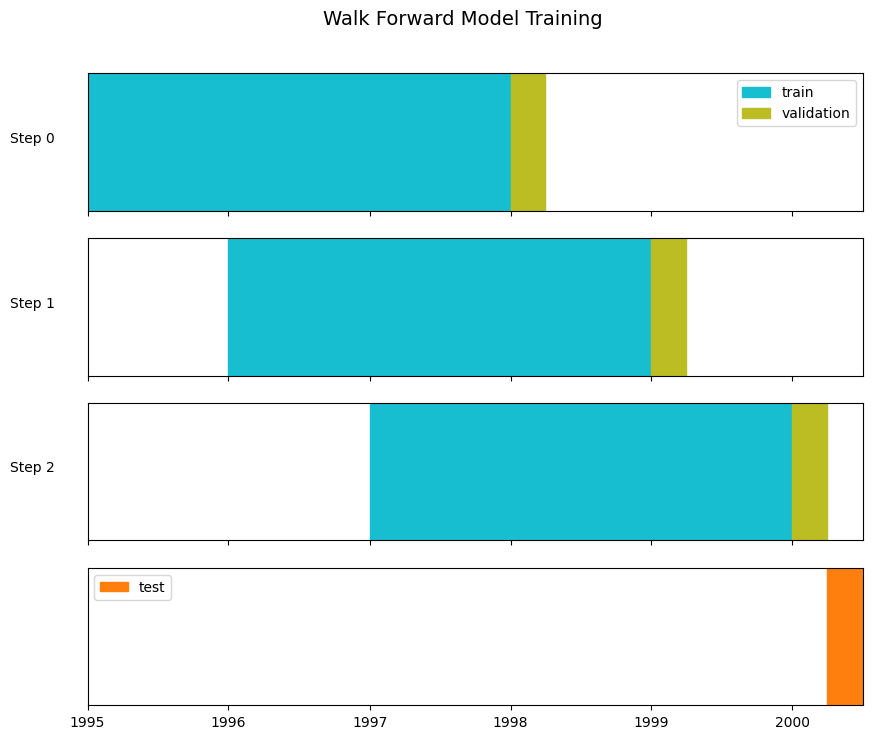

In [23]:
import matplotlib.dates as mdates

fig, ax = plt.subplots(total_split+1, 1, figsize=(10, 8))
plt.subplots_adjust(hspace=0.2)

j = 0 

for i in range(total_split):
    print('i = ',i)
    ax[j].axvspan(ymin=0, ymax=1, xmin=df.index[begin_train_ind_list[i]], xmax=df.index[end_train_ind_list[i]], color='tab:cyan', label='train')
    ax[j].axvspan(ymin=0, ymax=1, xmin=df.index[begin_val_ind_list[i]], xmax=df.index[end_val_ind_list[i]], color='tab:olive', label='validation')
    ax[j].text(-0.1,0.5, "Step {}".format(j), transform = ax[j].transAxes)
    j = j+1
    
ax[0].legend(loc='best')

ax[total_split].axvspan(ymin=0, ymax=1, xmin=df.index[begin_test_ind], xmax=df.index[end_test_ind], color='C1', label='test')

ax[total_split].legend(loc='best')

for j in range(total_split+1):
    ax[j].set_xlim(df.index[0], df.index[-1])
    ax[j].set_ylim(0,1)
    ax[j].set_yticks([]) 
    
for k in range(total_split):
        plt.setp(ax[k].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Walk Forward Model Training", fontsize=14)

plt.show()

# Train the model with the data

## Launch the Tensorboard to track the training

In [24]:
%tensorboard --logdir logs/fit
#%tensorboard --logdir=logs/fit/ --host localhost --port 8008

## Continue the training (step 1 onwards) after obtaining the initial model

In [25]:
loss_score = []
mse_score = []

In [26]:
# Define paths for saving models 

folder_path = "Multivariate_LSTM_magnetic-prediction_Walk-Forward"
model_path = "Saved_models/" + str(folder_path)
fig_path = "Plots/" + str(folder_path)
data_path = "Saved_data/" + str(folder_path)

## Create paths if not exist
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
if not os.path.exists(fig_path):
    os.makedirs(fig_path)

if not os.path.exists(data_path):
    os.makedirs(data_path)

print("Data will be saved under ", data_path)
print("Plots will be saved to ", fig_path) 

Data will be saved under  Saved_data/Multivariate_LSTM_magnetic-prediction_Walk-Forward
Plots will be saved to  Plots/Multivariate_LSTM_magnetic-prediction_Walk-Forward


i = 1
1st Train interval:  1996-01-01 00:00:00 1998-12-31 23:00:00
1st Validation interval:  1999-01-01 00:00:00 1999-03-31 23:00:00
Epoch 1/50
103/103 [==============================] - ETA: 0s - loss: 0.0017
Epoch 1: val_loss improved from inf to 0.00218, saving model to Saved_models/Multivariate_LSTM_magnetic-prediction_Walk-Forward/Step1_weights.best.hdf5
103/103 [==============================] - 6s 44ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 2/50
102/103 [============================>.] - ETA: 0s - loss: 0.0016
Epoch 2: val_loss did not improve from 0.00218
103/103 [==============================] - 4s 41ms/step - loss: 0.0016 - val_loss: 0.0022
Epoch 3/50
103/103 [==============================] - ETA: 0s - loss: 0.0015
Epoch 3: val_loss improved from 0.00218 to 0.00200, saving model to Saved_models/Multivariate_LSTM_magnetic-prediction_Walk-Forward/Step1_weights.best.hdf5
103/103 [==============================] - 4s 40ms/step - loss: 0.0015 - val_loss: 0.0020
Epoch 4/50


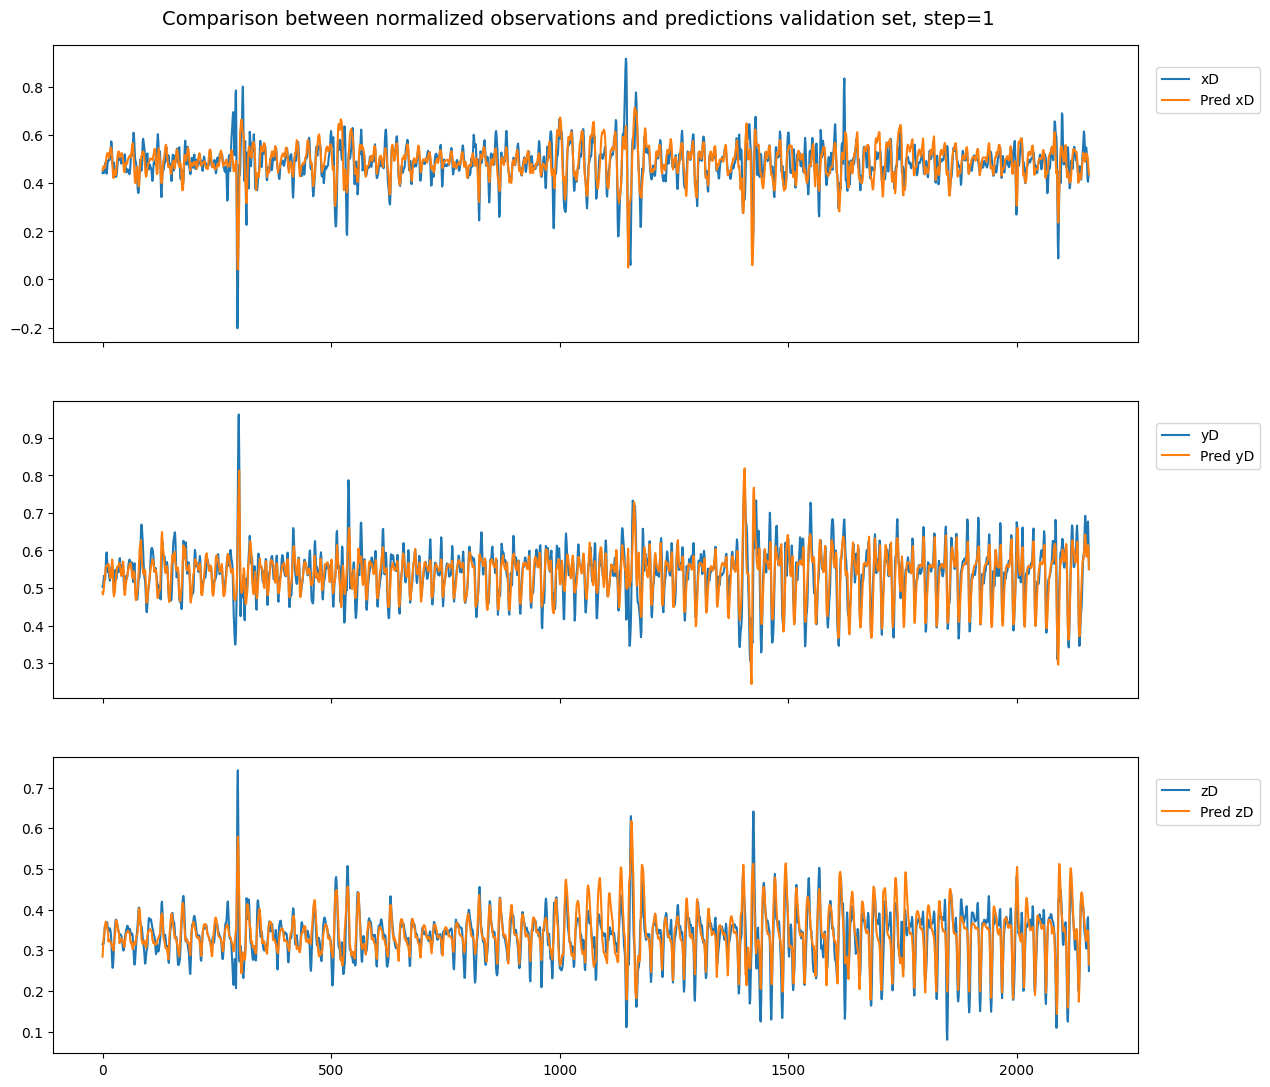

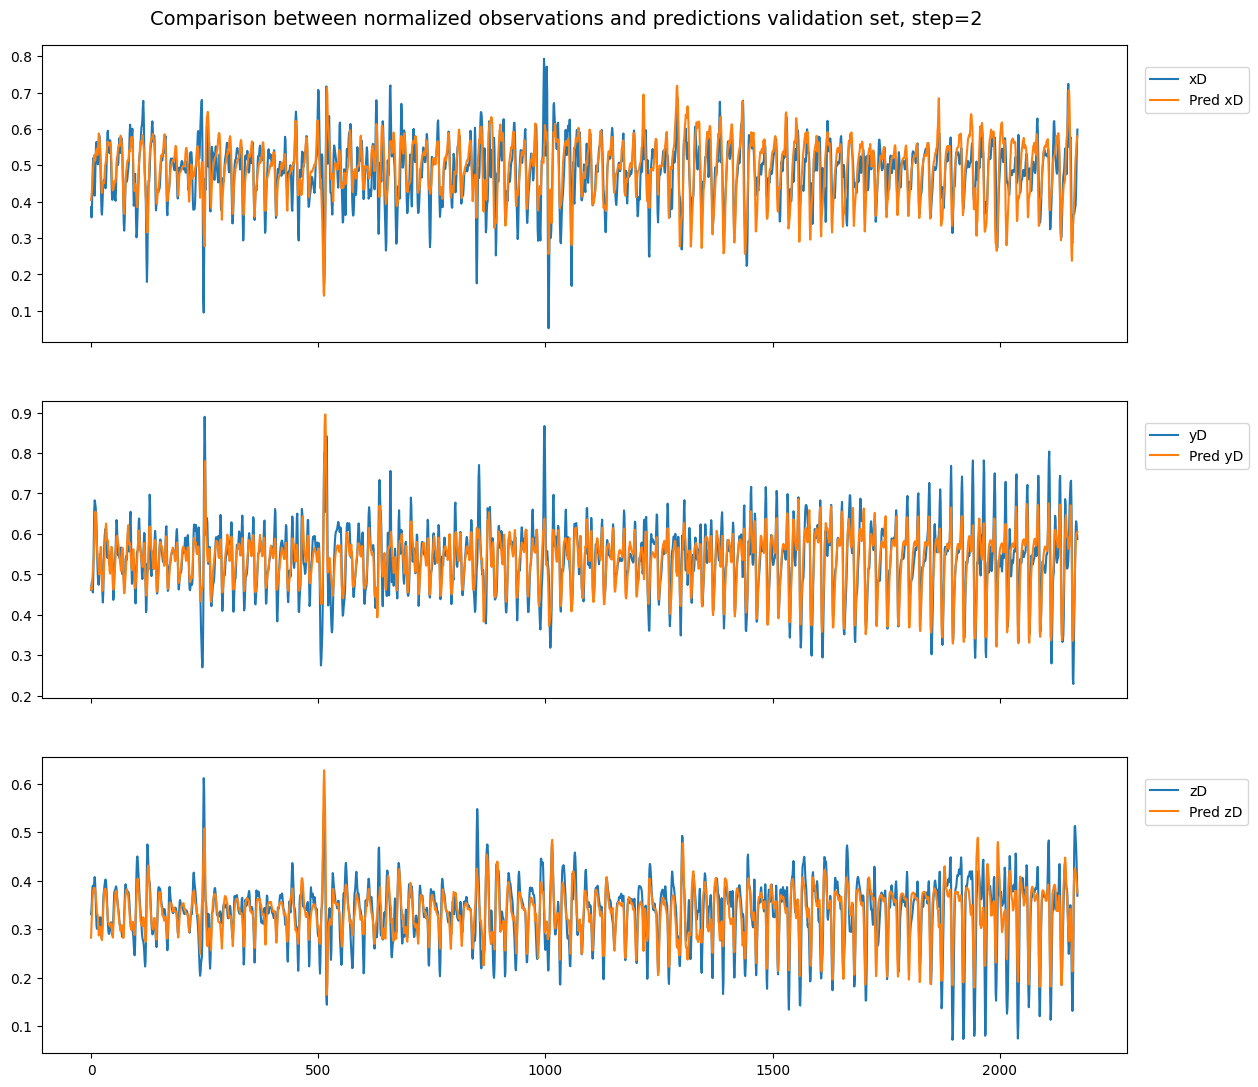

In [27]:
%%time

for i in range(1, total_split):
    print('i = {}'.format(i))
    
    X_tra = X_train_seq[begin_train_ind_list[i]:end_train_ind_list[i]]
    y_tra = y_train_seq[begin_train_ind_list[i]:end_train_ind_list[i]]

    print("1st Train interval: ",df.index[begin_train_ind_list[i]], df.index[end_train_ind_list[i]])

    X_val = X_train_seq[begin_val_ind_list[i]:end_val_ind_list[i]]
    y_val = y_train_seq[begin_val_ind_list[i]:end_val_ind_list[i]]

    print("1st Validation interval: ", df.index[begin_val_ind_list[i]], df.index[end_val_ind_list[i]])


    log_dir = "logs/fit/" + str(folder_path) + "_" + datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

    # checkpoint
    filepath= str(model_path) + "/Step{}_weights.best.hdf5".format(i)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)
    earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    
    
    # Load model from the previous round 
    if i == 1:
        loaded_model = tf.keras.models.load_model(initial_model)
    else:
        loaded_model = tf.keras.models.load_model(str(model_path) + "/Step{}_weights.best.hdf5".format(i-1))

    loaded_model.fit(X_tra, y_tra, epochs=50, 
          batch_size=256,
          validation_data=(X_val, y_val), 
          callbacks=[tensorboard_callback, earlystopping_callback, checkpoint])
    
    ### Generate generalization metrics
    print('Evaluation')
    score = loaded_model.evaluate(X_val, y_val, verbose=0)
    pred = loaded_model.predict(X_val)
    mse = mean_squared_error(y_val[:,0], pred[:,0])
    
    print(f'Test loss: ', score)
    print(f'MSE of first target: ', mse)
    
    loss_score.append(score)
    mse_score.append(mse)
    
    val_predict = loaded_model.predict(X_val)
    
    fig, ax = plt.subplots(len(output_targets), 1, figsize=(14,12))
    plt.subplots_adjust(hspace=0.2)

    target_labels = output_targets

    for k in range(y_val.shape[1]):
        ax[k].plot(y_val[:,k], label=target_labels[k])
        ax[k].plot(val_predict[:,k], label='Pred {}'.format(target_labels[k]))
        ax[k].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))

    for k in range(y_val.shape[1]-1):
        plt.setp(ax[k].get_xticklabels(), visible=False)

    fig = plt.gcf()
    fig.subplots_adjust(top=0.95)
    fig.suptitle("Comparison between normalized observations and predictions validation set, step={}".format(i), fontsize=14)

    figname = str(fig_path) + "/Validation_step{}.png".format(i)
    ax = plt.gca()
    ax.figure.savefig(figname, dpi=200, bbox_inches='tight', pad_inches=0.2)
    print('Fig saved to ', figname)


# Evaluate test result

In [28]:
df_test = df[t_test_begin:t_test_end]
df_test

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
2000-04-01 00:00:00,-6.5,-3.5,-2.5,353.0,8.2,27959.0,222.7,0.0,127.580,0.999339,14.835726,7.581761,-0.101153
2000-04-01 01:00:00,-6.9,-3.6,-2.2,354.0,7.0,27549.0,222.7,1.0,125.660,0.999351,12.268286,6.033439,-2.016603
2000-04-01 02:00:00,-7.0,-4.7,1.3,356.0,7.2,25704.0,222.7,2.0,120.810,0.999363,11.321350,4.124003,-2.515183
2000-04-01 03:00:00,-5.7,-6.3,0.3,363.0,7.9,28704.0,222.7,3.0,113.740,0.999376,11.755426,4.139001,-2.696133
2000-04-01 04:00:00,-3.4,-7.4,-1.9,365.0,9.2,29462.0,222.7,4.0,105.150,0.999388,12.061844,6.964977,-2.855630
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-06-30 19:00:00,0.9,-4.6,-2.7,386.0,4.1,24970.0,165.0,19.0,83.258,1.016709,11.855123,-3.697526,9.997287
2000-06-30 20:00:00,4.2,-2.5,-1.7,357.0,4.8,26835.0,165.0,20.0,91.723,1.016710,11.172871,1.993873,9.893249
2000-06-30 21:00:00,3.4,-3.3,-2.3,363.0,4.7,20001.0,165.0,21.0,98.957,1.016710,6.869253,3.717582,7.675454


## Scale the test data

In [29]:
df_test_scaled = load_scaler.transform(df_test)

print('Test data: \n',df_test_scaled)
print(df_test_scaled.shape)

Test data: 
 [[0.31707317 0.33333333 0.43927126 ... 0.59325468 0.58017282 0.33426148]
 [0.30313589 0.33105023 0.44534413 ... 0.57453236 0.57209796 0.31609902]
 [0.29965157 0.30593607 0.51619433 ... 0.56762711 0.56213981 0.31137144]
 ...
 [0.66202091 0.33789954 0.44331984 ... 0.53516148 0.56002024 0.40799994]
 [0.62020906 0.3173516  0.43117409 ... 0.50619251 0.54340554 0.38425698]
 [0.61324042 0.29223744 0.42712551 ... 0.49186948 0.52556377 0.37797611]]
(2184, 13)


In [30]:
X_test = df_test_scaled[:,0:len(input_features)]
y_test = df_test_scaled[:,len(input_features):len(input_features)+len(output_targets)]
X_test.shape, y_test.shape

((2184, 10), (2184, 3))

## Reshape the test data so that we can model them using the LSTM neural network

In [31]:
X_test_seq, y_test_seq = lstm_data_transform(X_test, y_test, num_steps=num_steps)
X_test_seq.shape, y_test_seq.shape

((2172, 12, 10), (2172, 3))

In [32]:
##Load the saved model 
filepath


'Saved_models/Multivariate_LSTM_magnetic-prediction_Walk-Forward/Step2_weights.best.hdf5'

In [33]:
model = tf.keras.models.load_model(filepath)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, None, 100)         44400     
                                                                 
 lstm_1 (LSTM)               (None, None, 50)          30200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 94,953
Trainable params: 94,953
Non-trainable params: 0
_________________________________________________________________


In [34]:
test_predict = model.predict(X_test_seq)
print(test_predict.shape)

68/68 [==============================] - 1s 4ms/step
(2172, 3)


## Model performance on the test data

In [35]:
#print('Test: \n', df[t_test_begin:t_test_end])

score_test = model.evaluate(X_test_seq, y_test_seq, verbose=1)
print('\nLoss score = ', score_test)

mse_test = []
for i in range(y_test_seq.shape[1]):
    mse_test.append(mean_squared_error(y_test_seq[:,i], test_predict[:,i]))
print('\nMSE of all targets = ', mse_test)

Pcc_xyz_test = []
for i in range(y_test_seq.shape[1]):
    Pcc_xyz_test.append(round(np.corrcoef(y_test_seq[:,i], test_predict[:,i])[0,1],3))
print('\nPcc of all targets = ', Pcc_xyz_test)


68/68 [==============================] - 1s 4ms/step - loss: 0.0035

Loss score =  0.0035295693669468164

MSE of all targets =  [0.005373859000969968, 0.0025871260570367667, 0.002627723060489016]

Pcc of all targets =  [0.69, 0.916, 0.908]


## Visualize model results on the test set with metrics

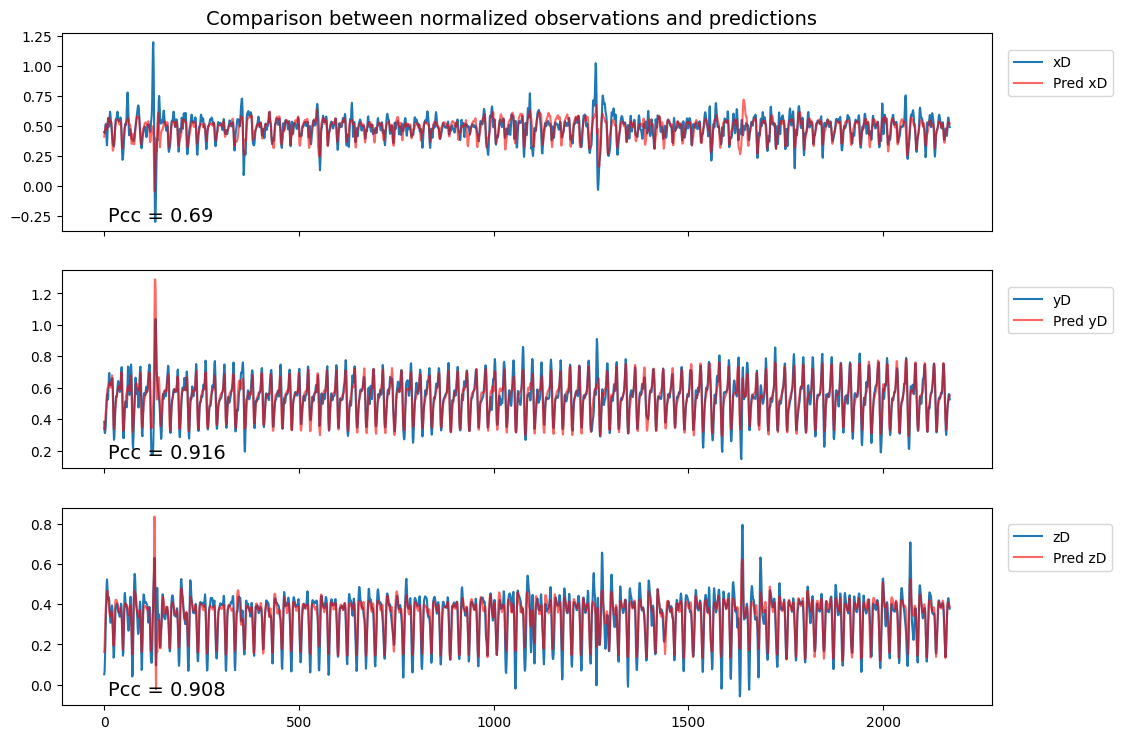

In [36]:
fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)
#plt.style.use('ggplot')

target_labels = output_targets

for i in range(y_test_seq.shape[1]):
    ax[i].plot(y_test_seq[:,i], label=target_labels[i])
    ax[i].plot(test_predict[:,i], label='Pred {}'.format(target_labels[i]), color='r', alpha=0.6)
    ax[i].legend(loc='upper left',bbox_to_anchor=(1.01, 0.95))
    text = str('Pcc = {}'.format(Pcc_xyz_test[i]))
    ax[i].text(0.05, 0.05, text, fontsize=14, transform=ax[i].transAxes)
    
for i in range(y_test_seq.shape[1]-1):
    plt.setp(ax[i].get_xticklabels(), visible=False)

fig = plt.gcf()
fig.subplots_adjust(top=0.95)
fig.suptitle("Comparison between normalized observations and predictions", fontsize=14)

plt.show()

## Scale back the data

### Concatenate the scaled 'X' and the 'test predict'

In [37]:
predict_scaled = np.concatenate((X_test_seq[:,0,:],test_predict), axis=1)
print(predict_scaled.shape)
print(predict_scaled)

(2172, 13)
[[0.31707317 0.33333333 0.43927126 ... 0.4122262  0.344219   0.16241547]
 [0.30313589 0.33105023 0.44534413 ... 0.4369863  0.33411732 0.19816947]
 [0.29965157 0.30593607 0.51619433 ... 0.45530841 0.36583522 0.27095118]
 ...
 [0.54006969 0.31050228 0.45748988 ... 0.53063178 0.53167421 0.40164554]
 [0.52264808 0.30593607 0.44736842 ... 0.52748209 0.54292524 0.39429972]
 [0.59930314 0.29223744 0.48582996 ... 0.52267748 0.55378509 0.38741851]]


### Unscale the scaled independent (X) variables and the modeling results (Y_modeled)

In [38]:
predict = load_scaler.inverse_transform(predict_scaled)
print(predict)
print(predict.shape)

[[ -6.5         -3.5         -2.5        ...  -9.98918409 -37.66145002
  -18.22438099]
 [ -6.9         -3.6         -2.2        ...  -6.59376695 -39.59840639
  -14.45369222]
 [ -7.          -4.7          1.3        ...  -4.08120789 -33.51662535
   -6.77798544]
 ...
 [ -0.1         -4.5         -1.6        ...   6.24808399  -1.71765638
    7.00530651]
 [ -0.6         -4.7         -2.1        ...   5.81615897   0.43968452
    6.23060087]
 [  1.6         -5.3         -0.2        ...   5.15729002   2.52201719
    5.50489482]]
(2172, 13)


### Create a dataframe and concatenate back the timestamps

In [39]:
df_predict = pd.DataFrame(predict)
df_predict.columns = new_column_order

df_predict['time'] = df.index[begin_test_ind+num_steps:end_test_ind+num_steps]
df_predict = df_predict.set_index(['time'])
df_predict

,Bx_gse,By_gsm,Bz_gsm,V,N,Temp,F10.7,local_time,SZA,DistSE,xD,yD,zD
time,,,,,,,,,,,,,
2000-04-01 12:00:00,-6.5,-3.5,-2.5,353.0,8.2,27959.0,222.7,0.0,127.580,0.999339,-9.989184,-37.661450,-18.224381
2000-04-01 13:00:00,-6.9,-3.6,-2.2,354.0,7.0,27549.0,222.7,1.0,125.660,0.999351,-6.593767,-39.598406,-14.453692
2000-04-01 14:00:00,-7.0,-4.7,1.3,356.0,7.2,25704.0,222.7,2.0,120.810,0.999363,-4.081208,-33.516625,-6.777985
2000-04-01 15:00:00,-5.7,-6.3,0.3,363.0,7.9,28704.0,222.7,3.0,113.740,0.999376,-0.050687,-23.489186,0.973474
2000-04-01 16:00:00,-3.4,-7.4,-1.9,365.0,9.2,29462.0,222.7,4.0,105.150,0.999388,2.273610,-16.715919,5.676469
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2000-06-30 19:00:00,4.3,-0.7,0.5,376.0,3.5,58260.0,165.0,7.0,62.283,1.016698,6.262102,-6.576448,7.871056
2000-06-30 20:00:00,3.3,-1.8,0.0,383.0,3.5,43124.0,165.0,8.0,52.234,1.016699,6.567506,-3.835659,7.771350
2000-06-30 21:00:00,-0.1,-4.5,-1.6,403.0,2.8,16689.0,165.0,9.0,42.446,1.016700,6.248084,-1.717656,7.005307


# Visualize rescaled prediction versus observation (final results)

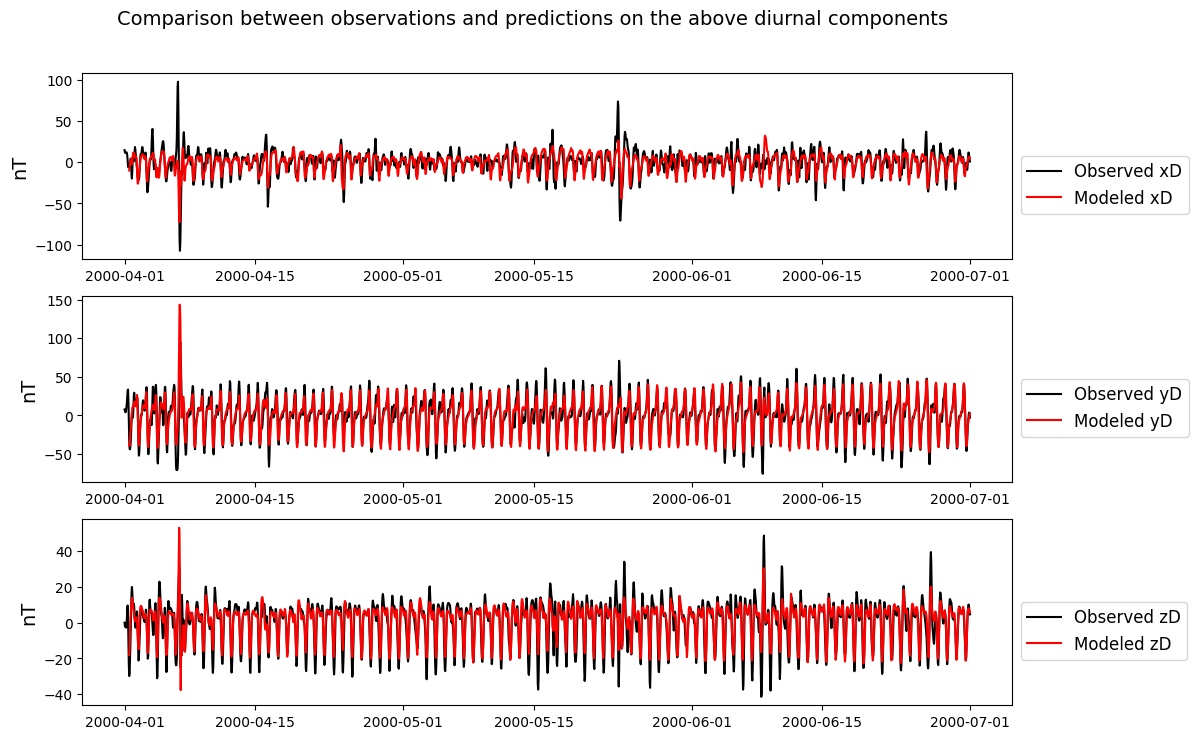

In [40]:
output_targets = ['xD','yD','zD']

fig, ax = plt.subplots(len(output_targets), 1, figsize=(12,8))
plt.subplots_adjust(hspace=0.2)

j = 0
for col in output_targets:
    if j < len(output_targets):
        ax[j].plot(df0[t_test_begin:t_test_end][col], label='Observed ' + col, color='k')
        ax[j].plot(df_predict[col], label='Modeled ' + col, color='r')
        ax[j].legend(loc='upper left',bbox_to_anchor=(1., .6),ncols=1, fontsize=12)
        ax[j].set_ylabel('nT', fontsize=14)
        ax[j].xaxis.get_label().set_fontsize(16)
        j += 1

fig = plt.gcf()
fig.subplots_adjust(top=0.9)
fig.suptitle("Comparison between observations and predictions on the above diurnal components", fontsize=14)

plt.show()